<a href="https://colab.research.google.com/github/Raunaq2001/Astronomy-Facts/blob/main/Hybrid_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 5.4 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705372 sha256=0026c6530cb5b3cbf6316f463250ff934ff38c732cf099bffc8009242f5bf1da
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [ ]:
from copy import deepcopy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "Uploading_Data_Colab_1.xlsx" with length 9000 bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving u.data to u (1).data
Saving u.item to u (1).item
Saving u.user to u (1).user
User uploaded file "Uploading_Data_Colab_1.xlsx" with length 9000 bytes
User uploaded file "Uploading_Data_Colab_1.xlsx" with length 9000 bytes
User uploaded file "Uploading_Data_Colab_1.xlsx" with length 9000 bytes


In [ ]:
interactions = pd.read_csv("u.data", sep="\t", header=None)
interactions.columns = ["user_id", "movie_id", "rating", "time"]
interactions["time"] = pd.to_datetime(interactions["time"],unit="s")
# Filter on ratings 3 or higher
interactions = interactions[interactions["rating"] >= 3]
interactions

,user_id,movie_id,rating,time
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
5,298,474,4,1998-01-07 14:20:06
7,253,465,5,1998-04-03 18:34:27
8,305,451,3,1998-02-01 09:20:17
...,...,...,...,...
99992,721,262,3,1997-10-18 01:14:45
99994,378,78,3,1997-11-20 20:16:16
99995,880,476,3,1997-11-22 05:10:44
99996,716,204,5,1997-11-17 19:39:03


In [ ]:
user_features = pd.read_csv("u.user", sep="|", header=None)
user_features.columns = ["user_id", "age", "gender", "occupation", "zip_code"]

user_features

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [ ]:
item_features = pd.read_csv("u.item", sep="|", header=None,encoding='latin-1')
item_features.columns = [
    "movie_id", "movie_title", "release_date", "video_release_date",
    "IMDb_URL", "unknown", "Action", "Adventure", "Animation",
    "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
    "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
    "Thriller", "War", "Western",
]
movie_titles = item_features[["movie_id", "movie_title"]]
item_features["release_date"] = pd.to_datetime(item_features["release_date"])
item_features = item_features.drop(columns = ["movie_title", "video_release_date", "IMDb_URL", "unknown"])
item_features

,movie_id,release_date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1995-01-01,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1995-01-01,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,1995-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,1995-01-01,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,1995-01-01,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,1998-02-06,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,1998-02-06,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1680,1998-01-01,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1681,1994-01-01,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
user_features = user_features.drop(columns=["age", "zip_code"])

In [ ]:
user_features = user_features \
    .drop(columns=["gender", "occupation"]) \
    .join(
        pd.get_dummies(user_features[["gender", "occupation"]])
    )

In [ ]:
user_features

,user_id,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,939,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
939,940,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
940,941,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
941,942,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
item_features = item_features.drop(columns=["release_date"])

In [ ]:
item_features

,movie_id,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1680,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1681,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def get_split_time(interactions, current_ratio):
    split_time = interactions \
        .sort_values("time") \
        .reset_index() \
        .iloc[int(interactions.shape[0] * current_ratio)] \
        ["time"]
    return split_time

def current_new_split(interactions, current_ratio):
    split_time = get_split_time(interactions, current_ratio)

    interactions_current = interactions[interactions["time"] < split_time]
    interactions_new = interactions[interactions["time"] >= split_time]
    
    return interactions_current, interactions_new
    
interactions_current, interactions_new = current_new_split(interactions, 0.9)

In [ ]:
interactions_current

,user_id,movie_id,rating,time
0,196,242,3,1997-12-04 15:55:49
5,298,474,4,1998-01-07 14:20:06
8,305,451,3,1998-02-01 09:20:17
9,6,86,3,1997-12-31 21:16:53
11,286,1014,5,1997-11-17 15:38:45
...,...,...,...,...
99992,721,262,3,1997-10-18 01:14:45
99994,378,78,3,1997-11-20 20:16:16
99995,880,476,3,1997-11-22 05:10:44
99996,716,204,5,1997-11-17 19:39:03


In [ ]:
interactions_new

,user_id,movie_id,rating,time
1,186,302,3,1998-04-04 19:22:22
7,253,465,5,1998-04-03 18:34:27
21,167,486,4,1998-04-16 14:54:12
26,38,95,5,1998-04-13 01:14:54
69,223,274,4,1998-04-02 20:48:14
...,...,...,...,...
99921,659,657,5,1998-03-31 22:39:25
99942,363,181,5,1998-04-02 05:26:23
99953,655,913,4,1998-04-05 23:05:21
99988,421,498,4,1998-04-10 20:49:04


In [ ]:
new_users = np.setdiff1d(interactions_new["user_id"], interactions_current["user_id"])
old_users = np.intersect1d(interactions_new["user_id"], interactions_current["user_id"])

print("Number of new users in new set: {}".format(len(new_users)))
print("Number of current users in new set: {}".format(len(old_users)))

Number of new users in new set: 76
Number of current users in new set: 86


In [ ]:
new_items = np.setdiff1d(interactions_new["movie_id"], interactions_current["movie_id"])
old_items = np.intersect1d(interactions_new["movie_id"], interactions_current["movie_id"])

print("Number of new items in new set: {}".format(len(new_items)))
print("Number of current items in new set: {}".format(len(old_items)))

Number of new items in new set: 49
Number of current items in new set: 1167


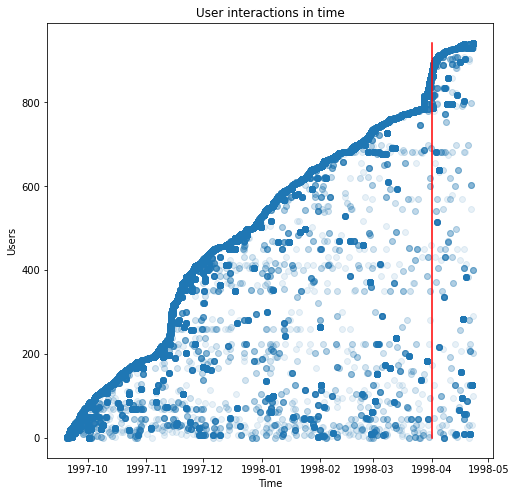

In [ ]:
users_first_interactions = interactions \
    .groupby("user_id") \
    .agg({"time": "min"}) \
    .reset_index() \
    .rename(columns={"time": "first_time"})
users_first_interactions = users_first_interactions.sort_values("first_time")
users_first_interactions["first_rank"] = range(users_first_interactions.shape[0])

interactions_first_time = interactions.merge(users_first_interactions, on="user_id")

split_time = get_split_time(interactions, 0.9)
plt.figure(figsize=(8, 8))
plt.scatter(
    interactions_first_time["time"],
    interactions_first_time["first_rank"],
    alpha=0.1
)
plt.plot(
    [split_time, split_time],
    [interactions_first_time["first_rank"].min(), interactions_first_time["first_rank"].max()],
    color="red"
)
plt.title(
    "User interactions in time"
)
plt.xlabel("Time")
plt.ylabel("Users")
plt.show()

In [ ]:
def train_test_split_randomly(data, test_size):
    """
    Randomly splits interactions to train and test.
    
    Makes sure there is at least 1 interaction for every user and item in the train set.
    """
    
    # Split randomly
    random_numbers = np.random.uniform(size=data.shape[0])
    test_mask = random_numbers <= test_size
    data_train = data[~test_mask]
    data_test = data[test_mask]
    
    # Make sure there is at least 1 interaction for every user and item in the train set
    for id_name in ["user_id", "movie_id"]:
        training_ids = data_train[id_name].unique()
        for id_ in data[id_name].unique():
            if id_ not in training_ids:
                row_to_training = data_test[data_test[id_name] == id_].sample(n=1)
                data_test = data_test.drop(index=row_to_training.index)
                data_train = data_train.append(row_to_training)
                
    return data_train, data_test


interactions_current_train, interactions_current_val = train_test_split_randomly(interactions_current, 0.3)

In [ ]:
interactions_current_train

,user_id,movie_id,rating,time
0,196,242,3,1997-12-04 15:55:49
8,305,451,3,1998-02-01 09:20:17
9,6,86,3,1997-12-31 21:16:53
11,286,1014,5,1997-11-17 15:38:45
12,200,222,5,1997-10-05 09:05:40
...,...,...,...,...
92998,939,424,3,1997-11-23 05:13:39
95179,752,1463,4,1998-03-29 21:51:01
95312,663,1327,4,1998-03-10 01:26:50
97353,799,1545,4,1997-11-11 13:13:46


In [ ]:
interactions_current_val

,user_id,movie_id,rating,time
5,298,474,4,1998-01-07 14:20:06
14,224,29,3,1998-02-21 23:40:57
16,122,387,5,1997-11-11 17:47:39
22,299,144,4,1997-10-26 15:55:20
29,160,234,5,1997-10-14 20:33:05
...,...,...,...,...
99962,650,479,5,1998-03-31 19:25:39
99975,537,443,3,1998-01-28 23:55:52
99983,646,750,3,1998-02-26 21:35:02
99989,495,1091,4,1998-02-28 03:45:03


In [ ]:
user_features_current = user_features[user_features["user_id"].isin(interactions_current["user_id"])]
user_features_new = user_features[user_features["user_id"].isin(interactions_new["user_id"])]

print("Number of current users: {}".format(len(user_features_current)))
print("Number of new users: {}".format(len(user_features_new)))

Number of current users: 867
Number of new users: 162


In [ ]:
item_features_current = item_features[item_features["movie_id"].isin(interactions_current["movie_id"])]
item_features_new = item_features[item_features["movie_id"].isin(interactions_new["movie_id"])]

print("Number of current items: {}".format(len(item_features_current)))
print("Number of new items: {}".format(len(item_features_new)))

Number of current items: 1525
Number of new items: 1216


In [ ]:
print("Max user id: {}".format(interactions_current['user_id'].max()))
print("Max movie id: {}".format(interactions_current['movie_id'].max()))

Max user id: 943
Max movie id: 1682


In [ ]:
user_ids_buffered = range(1000)
item_ids_buffered = range(1700)

user_feature_names = user_features.columns.tolist()
user_feature_names.remove("user_id")

item_feature_names = item_features.columns.tolist()
item_feature_names.remove("movie_id")

dataset = Dataset()
dataset.fit(
    users=user_ids_buffered,
    items=item_ids_buffered,
    user_features=user_feature_names,
    item_features=item_feature_names
)

In [ ]:
def transform_interactions(interactions):
    """
    Transforms interactions data frame to the format build_interactions needs it.
    
    Returns iterable of tuples (user_id, movie_id, weight).
    """
    return interactions[["user_id", "movie_id", "rating"]].itertuples(index=False)

In [ ]:
interaction_matrix_current, _ = dataset.build_interactions(
    transform_interactions(interactions_current))

interaction_matrix_current_train, _ = dataset.build_interactions(
    transform_interactions(interactions_current_train))

interaction_matrix_current_val, _ = dataset.build_interactions(
    transform_interactions(interactions_current_val))

In [ ]:
print(interaction_matrix_current.shape)
print(interaction_matrix_current_train.shape)
print(interaction_matrix_current_val.shape)

(1000, 1700)
(1000, 1700)
(1000, 1700)


In [ ]:
def transform_features(features, id_name):
    """
    Transforms features data frame to the format build_user_features / build_item_features needs it.
    
    Returns iterable of (id, [list of feature names that has value 1]).
    """
    transformed_features = []
    for row in features.to_dict(orient="records"):
        id_value = row[id_name]
        del row[id_name]
        feature_names = [key for key, value in row.items() if value == 1]
        transformed_features.append(
            (id_value, feature_names)
        )
    return transformed_features

In [ ]:
user_features_matrix_current = dataset.build_user_features(
    transform_features(user_features_current, "user_id"))

item_features_matrix_current = dataset.build_item_features(
    transform_features(item_features_current, "movie_id"))

In [ ]:
model = LightFM(loss="warp")

In [ ]:
class Evaluator():
    """
    Helper class for model evaluation
    
    Stores the number of epochs and corresponding performance metrics in a data frame.
    Returns the number of epochs with the best validation ROC AUC.
    Prepared to handle multiple runs of the same hyperparameters, and averages up the multiple runs.
    """
    
    def __init__(self):
        self.df_evaluation = pd.DataFrame()
    def evaluate(self, epochs, model, interaction_matrix_train, interaction_matrix_val, user_features_matrix, item_features_matrix):
            features_current = {
                "user_features": user_features_matrix,
                "item_features": item_features_matrix
            }
            evaluation_row = pd.DataFrame({
                "epochs": epochs,
                "train_precision": precision_at_k(model, interaction_matrix_train, k=10, **features_current).mean(),
                "validation_precision": precision_at_k(model, interaction_matrix_val, k=10, **features_current).mean(),
                "train_auc": auc_score(model, interaction_matrix_train, **features_current).mean(),
                "validation_auc": auc_score(model, interaction_matrix_val, **features_current).mean()
                },
                index=[0]
            )
            self.df_evaluation = self.df_evaluation.append(evaluation_row, ignore_index=True)
    def get_best_epochs(self):
        df_evaluation_agg = self.df_evaluation.groupby("epochs").agg("mean").reset_index()
        best_epochs =  df_evaluation_agg[
            df_evaluation_agg["validation_auc"] == df_evaluation_agg["validation_auc"].max()
        ]["epochs"].iloc[0]
        return best_epochs

In [ ]:
evaluator = Evaluator()
for epochs in [100, 200, 300, 500, 1000, 2000]:
    print(f"Epochs: {epochs}")
    
    model.fit(
        interaction_matrix_current_train,
        epochs=epochs,
        user_features=user_features_matrix_current,
        item_features=item_features_matrix_current
    )
    
    evaluator.evaluate(
        epochs, model,
        interaction_matrix_current_train, interaction_matrix_current_val,
        user_features_matrix_current, item_features_matrix_current)

Epochs: 100
Epochs: 200
Epochs: 300
Epochs: 500
Epochs: 1000
Epochs: 2000


In [ ]:
evaluator.df_evaluation

,epochs,train_precision,validation_precision,train_auc,validation_auc
0,100,0.397809,0.150115,0.906343,0.885351
1,200,0.434602,0.163972,0.920012,0.894667
2,300,0.487313,0.175751,0.936786,0.908150
3,500,0.507382,0.174249,0.946754,0.915741
4,1000,0.533103,0.176674,0.954895,0.919937
5,2000,0.540946,0.169400,0.958273,0.919324


In [ ]:
best_epochs = evaluator.get_best_epochs()
print(f"Best number of epochs: {best_epochs}")

model.fit(
    interaction_matrix_current,
    epochs=best_epochs,
    user_features=user_features_matrix_current,
    item_features=item_features_matrix_current
)

Best number of epochs: 1000


In [ ]:
interaction_matrix_new, _ = dataset.build_interactions(
    transform_interactions(interactions_new))

user_features_matrix_new = dataset.build_user_features(
    transform_features(user_features_new, "user_id"))

item_features_matrix_new = dataset.build_item_features(
    transform_features(item_features_new, "movie_id"))

In [ ]:
print(interaction_matrix_new.shape)
print(user_features_matrix_new.shape)
print(item_features_matrix_new.shape)

(1000, 1700)
(1000, 1023)
(1700, 1718)


In [ ]:
user_features_matrix = dataset.build_user_features(
    transform_features(user_features, "user_id"))

item_features_matrix = dataset.build_item_features(
    transform_features(item_features, "movie_id"))

In [ ]:
evaluator = Evaluator()
for epochs in [100, 500, 1000, 2000]:
    print(f"Epochs: {epochs}")

    num_fold = 5
    for fold in range(num_fold):
        print(f"fold: {fold}")
              
        interactions_new_train, interactions_new_val = train_test_split_randomly(interactions_new, 1/num_fold)
        interaction_matrix_new_train, _ = dataset.build_interactions(
            transform_interactions(interactions_new_train))
        interaction_matrix_new_val, _ = dataset.build_interactions(
            transform_interactions(interactions_new_val))
        
        model_fold = deepcopy(model)
        model_fold.fit_partial(
            interaction_matrix_new_train,
            user_features=user_features_matrix_new,
            item_features=item_features_matrix_new,
            epochs=epochs
        )

        evaluator.evaluate(
            epochs, model_fold,
            interaction_matrix_new_train, interaction_matrix_new_val,
            user_features_matrix_new, item_features_matrix_new)

Epochs: 100
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
Epochs: 500
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
Epochs: 1000
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
Epochs: 2000
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4


In [ ]:
evaluator.df_evaluation.groupby("epochs").agg("mean").reset_index()

,epochs,train_precision,validation_precision,train_auc,validation_auc
0,100,0.308518,0.082193,0.897088,0.894916
1,500,0.344074,0.088019,0.928940,0.904833
2,1000,0.370617,0.076146,0.944146,0.902439
3,2000,0.396049,0.064431,0.959258,0.898182


In [ ]:
best_epochs = evaluator.get_best_epochs()
print(f"Best number of epochs: {best_epochs}")

model.fit_partial(
    interaction_matrix_new,
    user_features=user_features_matrix_new,
    item_features=item_features_matrix_new,
    epochs=best_epochs
)

Best number of epochs: 500


In [ ]:
def predict(model, dataset, user_item_pairs, user_features_matrix, item_features_matrix):
    user_id_mapping, user_feature_mapping, item_id_mapping, item_feature_mapping = dataset.mapping()
    predictions = model.predict(
        user_ids=np.array([user_id_mapping[x] for x in user_item_pairs["user_id"]]),
        item_ids=np.array([item_id_mapping[x] for x in user_item_pairs["movie_id"]]),
        user_features=user_features_matrix,
        item_features=item_features_matrix
    )
    
    df_predictions = user_item_pairs.copy()
    df_predictions["prediction"] = predictions
    
    return df_predictions

def merge_interactions(df_evaluation, interactions):
    df_evaluation = df_evaluation.merge(interactions[["user_id", "movie_id", "rating"]], on=["user_id", "movie_id"], how="left")
    df_evaluation["has_interaction"] = ~df_evaluation["rating"].isna()
    df_evaluation = df_evaluation.drop(columns="rating")
    return df_evaluation

In [ ]:
all_item_ids = np.unique(interactions["movie_id"])
user_sample_item_pairs = pd.DataFrame({
    "user_id": new_users[2],
    "movie_id": all_item_ids
})
predictions_sample = predict(model, dataset, user_sample_item_pairs, user_features_matrix, item_features_matrix)
predictions_sample = merge_interactions(predictions_sample, interactions)

In [ ]:
# Condense item features into a compact list per item
item_features_no_id = item_features.drop(columns="movie_id")
item_features_list_series = item_features_no_id.apply(
    lambda row: [item_features_no_id.columns[i] for i, x in enumerate(row) if x == 1],
    axis=1)
item_features_list = pd.DataFrame({
    "movie_id": item_features["movie_id"],
    "feature_list": item_features_list_series,
})

In [ ]:
predictions_sample = predictions_sample \
    .merge(movie_titles, on="movie_id") \
    .merge(item_features_list, on="movie_id")
predictions_sample = predictions_sample.sort_values("prediction", ascending=False)

In [ ]:
# Movies that user rated
# Changing the value of .head(X) X will result in X number of outputs
predictions_sample[predictions_sample["has_interaction"]].head(10)

,user_id,movie_id,prediction,has_interaction,movie_title,feature_list
99,27,100,-159.090485,True,Fargo (1996),"[Crime, Drama, Thriller]"
502,27,508,-159.267380,True,"People vs. Larry Flynt, The (1996)",[Drama]
8,27,9,-159.286316,True,Dead Man Walking (1995),[Drama]
287,27,288,-159.442856,True,Scream (1996),"[Horror, Thriller]"
735,27,742,-159.489136,True,Ransom (1996),"[Drama, Thriller]"
49,27,50,-159.812561,True,Star Wars (1977),"[Action, Adventure, Romance, Sci-Fi, War]"
120,27,121,-160.018845,True,Independence Day (ID4) (1996),"[Action, Sci-Fi, War]"
285,27,286,-160.095474,True,"English Patient, The (1996)","[Drama, Romance, War]"
297,27,298,-160.245117,True,Face/Off (1997),"[Action, Sci-Fi, Thriller]"
117,27,118,-160.552231,True,Twister (1996),"[Action, Adventure, Thriller]"


In [ ]:
# Top recommendations from the movies the user didn't watch
predictions_sample[~predictions_sample["has_interaction"]].head(10)

,user_id,movie_id,prediction,has_interaction,movie_title,feature_list
281,27,282,-158.924942,False,"Time to Kill, A (1996)",[Drama]
312,27,313,-159.041046,False,Titanic (1997),"[Action, Drama, Romance]"
257,27,258,-159.150635,False,Contact (1997),"[Drama, Sci-Fi]"
236,27,237,-159.187637,False,Jerry Maguire (1996),"[Drama, Romance]"
271,27,272,-159.333313,False,Good Will Hunting (1997),[Drama]
299,27,300,-159.474518,False,Air Force One (1997),"[Action, Thriller]"
585,27,591,-159.486053,False,Primal Fear (1996),"[Drama, Thriller]"
126,27,127,-159.513489,False,"Godfather, The (1972)","[Action, Crime, Drama]"
116,27,117,-159.543457,False,"Rock, The (1996)","[Action, Adventure, Thriller]"
275,27,276,-159.606750,False,Leaving Las Vegas (1995),"[Drama, Romance]"
